In [16]:
import numpy as np 
from sklearn.manifold import TSNE as t_sne
from sklearn.datasets import make_swiss_roll 
from sklearn.manifold import LocallyLinearEmbedding as lle
import matplotlib.pyplot as plt

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D

%matplotlib inline 

from ipywidgets import *
import pickle
import time



import plot_functions as PL
import helpers as HL
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section III B-2: Applying the Algorithms, t-SNE

In this section, an ordinary Swiss roll with 1000 data points and noise set to 0.01 is used. The effect of the  hyperparameters for t-SNE are explored. 

## Importing and plotting the data set: 

In [17]:
create=False
if create: 
    X, tsne_color, X_2d_tsne=HL.make_swissroll(n=1000, noise=0.01)
    pickle.dump( X, open("Pickles/X_tsne.pkl", "wb")) 
    pickle.dump( tsne_color, open("Pickles/color_tsne.pkl", "wb")) 
    pickle.dump( X_2d_tsne, open("Pickles/X_2d_tsne.pkl", "wb")) 
else: 
    tsne_color=pickle.load(open("Pickles/color_tsne.pkl", "rb"))
    X=pickle.load(open("Pickles/X_tsne.pkl", "rb"))
    X_2d_tsne=pickle.load(open("Pickles/X_2d_tsne.pkl", "rb"))
    

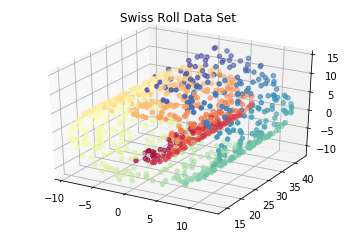

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=tsne_color, cmap=plt.cm.Spectral)
ax.set_title("Swiss Roll Data Set")
plt.savefig('dataset.pdf')
plt.show()

## Applying t-SNE

We want to apply the t-SNE algorithm, and play around with the hyperparameters.

# Analysing the effect of perpexity

In [19]:
"""Want to make an interactive plot with a wide range of perplexities. In order to do that we first create a list, Z,
consisting of a trnsformation for each perpelxity. It takes some time to create all of the transformations, therefore 
we have made them available in a pickle"""

per=np.arange(2,150,2) 
create=False
if create: 
    p_Z=[]
    p_times=np.zeros(len(per))
    p_kl_divergence=np.zeros(len(per))
    for i, p in enumerate(per):
        tsne=t_sne(perplexity=p)
        start_time=time.time()
        p_Z.append(tsne.fit_transform(X))
        p_times[i]= time.time()-start_time
        p_kl_divergence[i]=tsne.kl_divergence_
    pickle.dump( p_Z, open("Pickles/p_Z_tsne.pkl", "wb")) 
   
    pickle.dump(per, open("Pickles/per.pkl","wb"))
    pickle.dump(p_times, open("Pickles/p_times.pkl","wb"))
    pickle.dump(p_kl_divergence, open("Pickles/p_kl_divergence.pkl","wb"))
else: 
    p_Z= pickle.load(open("Pickles/p_Z_tsne.pkl", "rb"))
    per=pickle.load(open("Pickles/per.pkl", "rb"))
    p_times=pickle.load(open("Pickles/p_times.pkl", "rb"))
    p_kl_divergence=pickle.load(open("Pickles/p_kl_divergence.pkl", "rb"))
p_differences=HL.get_differences(X_2d_tsne,p_Z)

In [92]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

    
## K-means
"""
1. Calculate dist_matrix in original 2d_space
2. Get assignments from Kmeans in 2d_ after algorithm
3. sum up distances within cluster assignments from dist_matrix
3. sum all "clusters"

# 1.
orig_dist_mat = euclidean_distances(np.squeeze(X_2d_tsne).T, np.squeeze(X_2d_tsne).T)

# 2.
nb_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, random_state=0).fit(p_Z[10])
print("cluster centers: ", kmeans.cluster_centers_)

# 3. 
kmeans_metric = 0
for label in range(nb_clusters):
    print(label)
    print(orig_dist_mat.shape)
    boolean_label = kmeans.labels_==label
    cum_sum = 0
    for index, row in enumerate(orig_dist_mat):
        if boolean_label[index] == 1:
            print(row[boolean_label])
            cum_sum += np.sum(row[boolean_label])
    kmeans_metric += cum_sum
    print("cluster ",label)
    print("nb_labels:", sum(kmeans.labels_==label))
    print("sum", cum_sum)
print("\nKmeans model total:", kmeans_metric)
"""

def calculate_kmeans_metric(X_2d_orig, list_of_2d_manifolds, nb_clusters=2):
    # Calculate dist_matrix in original 2d_space
    orig_dist_mat = euclidean_distances(np.squeeze(X_2d_orig).T, np.squeeze(X_2d_orig).T)
    
    kmeans_metric_array = list()
    # loop through every 2d-transformation
    for manifold in list_of_2d_manifolds:
        kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, random_state=0).fit(manifold)
        
        kmeans_metric = 0
        # loop through every cluster
        for label in range(nb_clusters):
            #Get assignments from kmeans in 2d_ after algorithm
            boolean_label = kmeans.labels_==label
            cum_sum = 0
            # calculate distances to other datapoints in the same cluster
            for index, row in enumerate(orig_dist_mat):
                if boolean_label[index] == 1:
                    cum_sum += np.sum(row[boolean_label])
            kmeans_metric += cum_sum
            #print("cluster ",label)
            #print("nb_labels:", sum(kmeans.labels_==label))
            #print("sum", cum_sum)
        #print("\nKmeans model total:", kmeans_metric)
        kmeans_metric_array.append(kmeans_metric)
    return kmeans_metric_array


kmeans_metrics = calculate_kmeans_metric(X_2d_tsne, p_Z, nb_clusters=10)

In [93]:
interactive(PL.plot_inter, Z=fixed(p_Z), color=fixed(tsne_color),var=fixed(per),transformation=fixed('t-sne'),
            variable=fixed('per'), i=widgets.IntSlider(min=0,max=len(per)-1,step=1, value=0),
           error=fixed(p_kl_divergence),times=fixed(kmeans_metrics),difference=fixed(p_differences)
           ,error_type=fixed('KL divergence'))



A Jupyter Widget

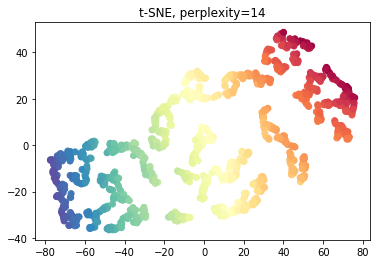

In [6]:
PL.plot_and_save_tsne(14, "per14.pdf",color=tsne_color, Z=p_Z)

# Analysing the effect of early exaggeration

In [7]:
early_exaggeration=np.arange(1,80,1) 
create=False
if create: 
    e_Z=[]
    e_times=np.zeros(len(early_exaggeration))
    e_kl_divergence=np.zeros(len(early_exaggeration))
    for i, e in enumerate(early_exaggeration):
        tsne=t_sne(early_exaggeration=e)
        start_time=time.time()
        e_Z.append(tsne.fit_transform(X))
        e_times[i]= time.time()-start_time
        e_kl_divergence[i]=tsne.kl_divergence_
    pickle.dump( e_Z, open("Pickles/e_Z_tsne.pkl", "wb")) 
    pickle.dump(early_exaggeration, open("Pickles/early_exaggeration.pkl","wb"))
    pickle.dump(e_times, open("Pickles/e_times.pkl","wb"))
    pickle.dump(e_kl_divergence, open("Pickles/e_kl_divergence.pkl","wb"))
else: 
    e_Z= pickle.load(open("Pickles/e_Z_tsne.pkl", "rb"))
    early_exaggeration=pickle.load(open("Pickles/early_exaggeration.pkl", "rb"))
    e_times=pickle.load(open("Pickles/e_times.pkl", "rb"))
    e_kl_divergence=pickle.load(open("Pickles/e_kl_divergence.pkl", "rb"))
e_differences=HL.get_differences(X_2d_tsne,e_Z)

In [8]:
interactive(PL.plot_inter, Z=fixed(e_Z), color=fixed(tsne_color),var=fixed(early_exaggeration),transformation=fixed('t-sne'),
            variable=fixed('early_exaggeration'), i=widgets.IntSlider(min=0,max=len(early_exaggeration)-1,step=1, value=0),
           error=fixed(e_kl_divergence),times=fixed(e_times),difference=fixed(e_differences)
           ,error_type=fixed('KL divergence'))



A Jupyter Widget

# Analysing the effect of learning rate

In [9]:
learning_rates=np.arange(5,1000,5) 
create=False
if create: 
    p=24
    l_Z=[]
    l_times=np.zeros(len(learning_rates))
    l_kl_divergence=np.zeros(len(learning_rates))
    for i, l in enumerate(learning_rates):
        tsne=t_sne(perplexity=p, learning_rate=l)
        start_time=time.time()
        l_Z.append(tsne.fit_transform(X))
        l_times[i]= time.time()-start_time
        l_kl_divergence[i]=tsne.kl_divergence_
    pickle.dump( l_Z, open("Pickles/l_Z_tsne.pkl", "wb")) 
    pickle.dump(learning_rates, open("Pickles/learning_rates.pkl","wb"))
    pickle.dump(l_times, open("Pickles/l_times.pkl","wb"))
    pickle.dump(l_kl_divergence, open("Pickles/l_kl_divergence.pkl","wb"))
else: 
    l_Z= pickle.load(open("Pickles/l_Z_tsne.pkl", "rb"))
    learning_rates=pickle.load(open("Pickles/learning_rates.pkl", "rb"))
    l_times=pickle.load(open("Pickles/l_times.pkl", "rb"))
    l_kl_divergence=pickle.load(open("Pickles/l_kl_divergence.pkl", "rb"))
l_differences=HL.get_differences(X_2d_tsne,l_Z)

In [10]:
interactive(PL.plot_inter, transformation=fixed('t-sne'), Z=fixed(l_Z), color=fixed(tsne_color),
            var=fixed(learning_rates),variable=fixed('learning_rate'), 
            i=widgets.IntSlider(min=0,max=len(learning_rates)-1,step=1, value=0),
           error=fixed(l_kl_divergence),times=fixed(l_times),difference=fixed(l_differences)
           ,error_type=fixed('KL divergence'))

A Jupyter Widget

# Analysing the effect of threshold on norm of gradient

In [11]:
threshold=np.logspace(-14,-1,50) 
create=False
if create: 
    p=24
    t_Z=[]
    t_times=np.zeros(len(threshold))
    t_kl_divergence=np.zeros(len(threshold))
    for i, t in enumerate(threshold):
        tsne=t_sne(perplexity=p, min_grad_norm=t)
        start_time=time.time()
        t_Z.append(tsne.fit_transform(X))
        t_times[i]= time.time()-start_time
        t_kl_divergence[i]=tsne.kl_divergence_
    pickle.dump( t_Z, open("Pickles/t_Z_tsne.pkl", "wb")) 
    pickle.dump(threshold, open("Pickles/threshold.pkl","wb"))
    pickle.dump(t_times, open("Pickles/t_times.pkl","wb"))
    pickle.dump(t_kl_divergence, open("Pickles/t_kl_divergence.pkl","wb"))
else: 
    t_Z= pickle.load(open("Pickles/t_Z_tsne.pkl", "rb"))
    threshold=pickle.load(open("Pickles/threshold.pkl", "rb"))
    t_times=pickle.load(open("Pickles/t_times.pkl", "rb"))
    t_kl_divergence=pickle.load(open("Pickles/t_kl_divergence.pkl", "rb"))
t_differences=HL.get_differences(X_2d_tsne,t_Z)

In [12]:

interactive(PL.plot_inter,transformation=fixed('t-sne'), Z=fixed(t_Z), color=fixed(tsne_color),var=fixed(threshold)
            ,variable=fixed('threshold'), i=widgets.IntSlider(min=0,max=len(threshold)-1,step=1, value=0),
           error=fixed(t_kl_divergence),times=fixed(t_times),difference=fixed(t_differences)
           ,error_type=fixed('KL divergence'))

A Jupyter Widget

In [ ]:
## K-means
"""
1. Calculate dist_matrix in original 2d_space
2. Get assignments from Kmeans in 2d_ after algorithm
3. sum up distances within cluster assignments from dist_matrix
3. sum all "clusters"
"""